In [88]:
# from transformers import BertTokenizer, BertModel
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy
import numpy as np

import random
import math
import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [90]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [91]:
"/content/drive/MyDrive/DLNLP project/socialnetwork.paraphrases.train.examples"
"/content/drive/MyDrive/DLNLP project/socialnetwork.paraphrases.test.examples"

with open('/content/drive/MyDrive/DLNLP project/publications.paraphrases.train.examples','r') as f:
  examples = f.readlines()
  lines = [e.strip().split('\n') for e in examples]


utterance = []
original = []

for line in lines:
  if line[0].find('(utterance') == 0:
    utterance.append(line[0][12:-2])
  if line[0].find('(original') == 0:
    original.append(line[0][11:-2])


import pandas as pd

df = pd.DataFrame({'utterance':utterance, 'original':original})

df['utterance'] = df['utterance'].apply(lambda x : ' '.join(x.split()))
df['original'] = df['original'].apply(lambda x : ' '.join(x.split()))
df.to_csv('train_data.csv',index=False)

with open('/content/drive/MyDrive/DLNLP project/publications.paraphrases.test.examples','r') as f:
  examples = f.readlines()
  lines = [e.strip().split('\n') for e in examples]


utterance = []
original = []

for line in lines:
  if line[0].find('(utterance') == 0:
    utterance.append(line[0][12:-2])
  if line[0].find('(original') == 0:
    original.append(line[0][11:-2])

df = pd.DataFrame({'utterance':utterance, 'original':original})

df['utterance'] = df['utterance'].apply(lambda x : ' '.join(x.split()))
df['original'] = df['original'].apply(lambda x : ' '.join(x.split()))
df.to_csv('test_data.csv',index=False)

In [92]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [93]:
train_df.tail()

,utterance,original
635,what article cites the fewest articles,article that cites the least number of article
636,what is an article that does not cite multivar...,article that multivariate data analysis not cites
637,find an article with no more than two venues,article that has at most two venue
638,name an article found in two venues,article that has two venue
639,what 2004 article was cited by multivariate da...,article whose publication date is 2004 and tha...


In [94]:
test_df.tail()

,utterance,original
156,who is the author of an article cited by multi...,person that is author of article that multivar...
157,which article won an award and has its venue a...,article that won an award and whose venue is a...
158,name an article about multivariate data analys...,article that cites multivariate data analysis ...
159,articles with two or more authors,article that has at least two author
160,articles that cite multivariate data analysis,article that cites article that cites multivar...


In [95]:
# spacy_en = spacy.load('en_core_web_sm')

def tokenizer(text):
  return bert_tokenizer.tokenize(text)

def normal_tokenizer(text):
  return text.split()

In [96]:
UTTERANCE = Field(sequential=True,
                  tokenize = normal_tokenizer,
                  use_vocab = True,
                  # preprocessing = bert_tokenizer.convert_tokens_to_ids, 
                  pad_token = 0,
                  lower = True)

ORIGINAL = Field(sequential=True,
                tokenize = normal_tokenizer, 
                use_vocab = True,            
                init_token = '<sos>',     
                eos_token = '<eos>',
                pad_token = 0,
                lower = True)

fields = [('utterance', UTTERANCE), ('original', ORIGINAL)] # ('token_type', TTYPE), ('start',START), ('end',END)]

In [97]:
train_data, test_data = TabularDataset.splits(
                                        path = '/content/',
                                        train = 'train_data.csv',
                                        test = 'test_data.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)
print(type(train_data))

<class 'torchtext.legacy.data.dataset.TabularDataset'>


In [98]:
UTTERANCE.build_vocab(train_data,test_data) # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'>
ORIGINAL.build_vocab(train_data,test_data)  # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'

In [99]:
len(ORIGINAL.vocab),len(UTTERANCE.vocab)

(46, 204)

In [100]:
BATCH_SIZE = 4

train_iterator, test_iterator = BucketIterator.splits(
                                                      (train_data, test_data), 
                                                      batch_size = BATCH_SIZE,
                                                      sort_key = lambda x : len(x.utterance),
                                                      shuffle = False,
                                                      device = device)

In [101]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, glove_emb, fasttext_emb, trainable):
        super().__init__()
        
        self.glove = nn.Embedding.from_pretrained(glove_emb)
        self.fasttext = nn.Embedding.from_pretrained(fasttext_emb)
        self.learnable = nn.Embedding(input_dim, emb_dim, padding_idx = 0)

        if trainable == True:
          self.glove.weight.requires_grad = True
          self.fasttext.weight.requires_grad = True
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True, batch_first = False)
        self.W_glove = nn.Linear(300,emb_dim)
        self.W_fasttext = nn.Linear(300,emb_dim)
        self.a = nn.Linear(emb_dim, 1)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.Softmax = nn.Softmax(dim=-1)
        src_len, batch_size, types = glove_emb.shape[0], glove_emb.shape[1], 2
        self.coeffs = torch.empty((src_len,batch_size,types))


    def plot_attn_graph(self):
      ftext = self.coeffs.mean(dim=1)[:,1].detach().cpu().numpy().tolist()
      glove = self.coeffs.mean(dim=1)[:,0].detach().cpu().numpy().tolist()
      learnable = self.coeffs.mean(dim=1)[:,2].detach().cpu().numpy().tolist()

      plt.plot(ftext,color='b')
      plt.plot(glove,color='r')
      plt.plot(learnable,color='g')
      plt.show()
      # print(f"Exact match : 13")
      
    def forward(self, src):
        
        #src = [src len, batch size]
        
        glove_embedded = self.dropout(self.W_glove(self.glove(src)))
        fasttext_embedded = self.dropout(self.W_fasttext(self.fasttext(src)))
        learnable_embedded = self.dropout(self.learnable(src))
        # type_embedded = [src len, batch size, emb dim]
        energy = torch.cat((self.a(glove_embedded),self.a(fasttext_embedded),self.a(learnable_embedded)),dim=-1)
        # [src len, batch size, 3], 3 = different types of embeddings used

        coeff = self.Softmax(energy)
        # [src len, batch size, 3]
        src_len = coeff.shape[0]

        self.coeffs = coeff
        
        for i in range(src_len):
          if i == 0:
            embedded = torch.bmm(coeff[i,:,:].unsqueeze(1), torch.stack((glove_embedded[i,:,:],fasttext_embedded[i,:,:],learnable_embedded[i,:,:]),dim=1)).squeeze(1)
            # print(embedded.shape) # [batch size, emb dim]
            embedded = embedded.unsqueeze(0)
          else:
            temp = torch.bmm(coeff[i,:,:].unsqueeze(1), torch.stack((glove_embedded[i,:,:],fasttext_embedded[i,:,:],learnable_embedded[i,:,:]),dim=1)).squeeze(1)
            embedded = torch.cat((embedded,temp.unsqueeze(0)),dim=0)

        # print(embedded.shape) # [src len, batch_size, emb dim]

        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [102]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1) # [b_z, src_len, dec hid dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(-1)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=-1)

In [103]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim,emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear( dec_hid_dim , output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        # assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        # prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [104]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        
        # <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs

In [105]:
import torchtext
glove = torchtext.vocab.GloVe(name='42B', dim=300)
fasttext = torchtext.vocab.FastText(language='en')

In [106]:
UTTERANCE.vocab.itos[0]

'<unk>'

In [107]:
glove_emb = []
fasttext_emb = []
for i in range(len(UTTERANCE.vocab)):
  try:
    glove_emb.append(glove[UTTERANCE.vocab.itos[i]].detach().cpu().numpy().tolist())
  except:
    glove_emb.append(glove[UTTERANCE.vocab.itos[0]].detach().cpu().numpy().tolist())

for i in range(len(UTTERANCE.vocab)):
  try:
    fasttext_emb.append(fasttext[UTTERANCE.vocab.itos[i]].detach().cpu().numpy().tolist())
  except:
    fasttext_emb.append(fasttext[UTTERANCE.vocab.itos[0]].detach().cpu().numpy().tolist())



In [108]:
INPUT_DIM = len(UTTERANCE.vocab)
OUTPUT_DIM = len(ORIGINAL.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128  
ENC_HID_DIM = 32
DEC_HID_DIM = 32
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

trainable = False
attn = Attention(ENC_HID_DIM, DEC_HID_DIM).to(device)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, torch.tensor(glove_emb), torch.tensor(fasttext_emb), trainable).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn).to(device)

model = Seq2Seq(enc, dec, device).to(device)

In [109]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)  #  initialise bias with 0
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (glove): Embedding(204, 300)
    (fasttext): Embedding(204, 300)
    (learnable): Embedding(204, 128, padding_idx=0)
    (rnn): GRU(128, 32, bidirectional=True)
    (W_glove): Linear(in_features=300, out_features=128, bias=True)
    (W_fasttext): Linear(in_features=300, out_features=128, bias=True)
    (a): Linear(in_features=128, out_features=1, bias=True)
    (fc): Linear(in_features=64, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (Softmax): Softmax(dim=-1)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=96, out_features=32, bias=True)
      (v): Linear(in_features=32, out_features=1, bias=False)
    )
    (embedding): Embedding(46, 128)
    (rnn): GRU(192, 32)
    (fc_out): Linear(in_features=32, out_features=46, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [110]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 168,719 trainable parameters


In [111]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

TRG_PAD_IDX = ORIGINAL.vocab.stoi[ORIGINAL.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [112]:

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(train_iterator):
        
        src = batch.utterance
        trg = batch.original

        # print(src.shape,src_mask.shape, trg.shape)
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [113]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.utterance
            trg = batch.original

            output = model(src, trg, 0) 

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size] , excludes '<sos>'
            #output = [(trg len - 1) * batch size, output dim],  excludes '<sos>'

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)



In [114]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [120]:
N_EPOCHS = 10
CLIP = 1

# best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq+dme-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} |  Val. Loss: {valid_loss:.3f}')


Epoch: 01 | Time: 0m 5s
	Train Loss: 0.597 |  Val. Loss: 1.619
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.620 |  Val. Loss: 1.583
Epoch: 03 | Time: 0m 5s
	Train Loss: 0.571 |  Val. Loss: 1.511
Epoch: 04 | Time: 0m 4s
	Train Loss: 0.548 |  Val. Loss: 1.607
Epoch: 05 | Time: 0m 5s
	Train Loss: 0.590 |  Val. Loss: 1.670
Epoch: 06 | Time: 0m 4s
	Train Loss: 0.527 |  Val. Loss: 1.569
Epoch: 07 | Time: 0m 4s
	Train Loss: 0.562 |  Val. Loss: 1.651
Epoch: 08 | Time: 0m 4s
	Train Loss: 0.536 |  Val. Loss: 1.549
Epoch: 09 | Time: 0m 4s
	Train Loss: 0.489 |  Val. Loss: 1.492
Epoch: 10 | Time: 0m 5s
	Train Loss: 0.475 |  Val. Loss: 1.685


In [121]:
model = Seq2Seq(enc, dec, device).to(device)
PATH = '/content/seq2seq+dme-model.pt'
# model.load_state_dict(torch.load(PATH, map_location=device))

In [122]:
def match(model, iterator):
    
    model.eval()
    
    epoch_loss = 0
    exact_match = 0
    op_list = []
    gold_list = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.utterance
            trg = batch.original
            # print(src)

            # for batch in iterator:
            #   for i in batch.original:
            #     print([ORIGINAL.vocab.itos[x] for x in i.detach().cpu().numpy().tolist()])

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            assert (trg.shape[0],trg.shape[1]) == (output.shape[0],output.shape[1])

            output_dim = output.shape[-1]
            
            output = output.argmax(dim=-1).permute(1,0)
            output[:,0] = 2
            trg = trg.permute(1,0)


            exact_match += torch.sum(torch.all(output == trg, dim=1))

            for b in range(trg.shape[0]):
              temp = []
              gemp = []
              for i in range(trg.shape[1]):
                temp.append(ORIGINAL.vocab.itos[output[b,i]])
                gemp.append(ORIGINAL.vocab.itos[trg[b,i]])
              op_list.append(temp)
              gold_list.append(gemp)


    return exact_match, op_list, gold_list


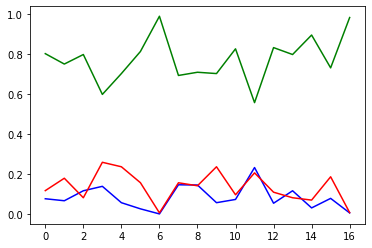

Exact match : 13


In [123]:
model.load_state_dict(torch.load(PATH,map_location=device))

exact_match, op_list, gold_list = match(model, test_iterator)

model.encoder.plot_attn_graph()

In [125]:
print(f'Exact match : {exact_match}')

Exact match : 51


In [126]:
len(df)

161